<a href="https://colab.research.google.com/github/Jiya9304/AIMLMonth2023/blob/main/Heart_Failure_Prediction_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Heart Failure Prediction Model

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
import joblib

In [30]:
# ---- STEP 1: Load dataset from Google Drive ----
# Install gdown if not installed: pip install gdown
import gdown

# Replace with your actual Google Drive link
url = "https://drive.google.com/uc?id=1qXOT7Dhr5ew001jlAsn6dj63uCFqHZaN"
output = "heart_dataset.csv"
gdown.download(url, output, quiet=False)



Downloading...
From: https://drive.google.com/uc?id=1qXOT7Dhr5ew001jlAsn6dj63uCFqHZaN
To: /content/heart_dataset.csv
100%|██████████| 11.3k/11.3k [00:00<00:00, 24.9MB/s]


'heart_dataset.csv'

In [31]:
df = pd.read_csv(output)
print("Dataset shape:", df.shape)
print(df.head())

Dataset shape: (303, 14)
   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   3       145   233    1        0      150      0      2.3      0   
1   37    1   2       130   250    0        1      187      0      3.5      0   
2   41    0   1       130   204    0        0      172      0      1.4      2   
3   56    1   1       120   236    0        1      178      0      0.8      2   
4   57    0   0       120   354    0        1      163      1      0.6      2   

   ca  thal  target  
0   0     1       1  
1   0     2       1  
2   0     2       1  
3   0     2       1  
4   0     2       1  


In [32]:
df.sample(5)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
234,70,1,0,130,322,0,0,109,0,2.4,1,3,2,0
24,40,1,3,140,199,0,1,178,1,1.4,2,0,3,1
49,53,0,0,138,234,0,0,160,0,0.0,2,0,2,1
277,57,1,1,124,261,0,1,141,0,0.3,2,0,3,0
157,35,1,1,122,192,0,1,174,0,0.0,2,0,2,1


In [34]:
#Description
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [38]:
# understand columns better
info = ["age","1: male, 0: female","chest pain type, 1: typical angina, 2: atypical angina, 3: non-anginal pain, 4: asymptomatic","resting blood pressure"," serum cholestoral in mg/dl","fasting blood sugar > 120 mg/dl","resting electrocardiographic results (values 0,1,2)"," maximum heart rate achieved","exercise induced angina","oldpeak = ST depression induced by exercise relative to rest","the slope of the peak exercise ST segment","number of major vessels (0-3) colored by flourosopy","thal: 3 = normal; 6 = fixed defect; 7 = reversable defect"]

for i in range(len(info)):
    print(df.columns[i]+":\t\t\t"+info[i])

age:			age
sex:			1: male, 0: female
cp:			chest pain type, 1: typical angina, 2: atypical angina, 3: non-anginal pain, 4: asymptomatic
trestbps:			resting blood pressure
chol:			 serum cholestoral in mg/dl
fbs:			fasting blood sugar > 120 mg/dl
restecg:			resting electrocardiographic results (values 0,1,2)
thalach:			 maximum heart rate achieved
exang:			exercise induced angina
oldpeak:			oldpeak = ST depression induced by exercise relative to rest
slope:			the slope of the peak exercise ST segment
ca:			number of major vessels (0-3) colored by flourosopy
thal:			thal: 3 = normal; 6 = fixed defect; 7 = reversable defect


In [39]:
df["target"].describe()

,target
count,303.000000
mean,0.544554
std,0.498835
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [40]:
df["target"].unique()

array([1, 0])

#Checking correlation between columns

In [42]:
print(df.corr()["target"].abs().sort_values(ascending=False))

target      1.000000
exang       0.436757
cp          0.433798
oldpeak     0.430696
thalach     0.421741
ca          0.391724
slope       0.345877
thal        0.344029
sex         0.280937
age         0.225439
trestbps    0.144931
restecg     0.137230
chol        0.085239
fbs         0.028046
Name: target, dtype: float64


#Exploratory Data Analysis (EDA)


target
1    165
0    138
Name: count, dtype: int64


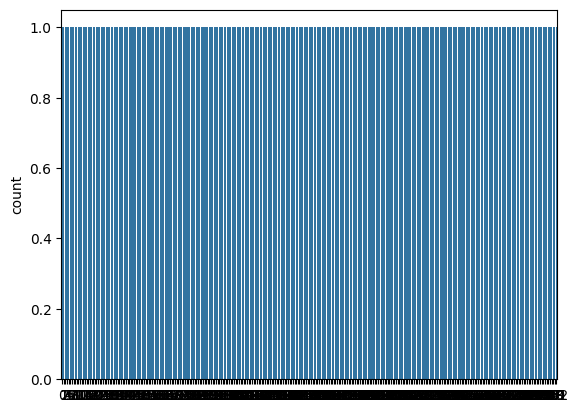

In [43]:
#First, analysing the target variable:
y = df["target"]
sns.countplot(y)
target_temp = df.target.value_counts()
print(target_temp)

In [44]:
print("Percentage of patience without heart problems: "+str(round(target_temp[0]*100/303,2)))
print("Percentage of patience with heart problems: "+str(round(target_temp[1]*100/303,2)))

#Alternatively,
# print("Percentage of patience with heart problems: "+str(y.where(y==1).count()*100/303))
# print("Percentage of patience with heart problems: "+str(y.where(y==0).count()*100/303))

# #Or,
# countNoDisease = len(df[df.target == 0])
# countHaveDisease = len(df[df.target == 1])

Percentage of patience without heart problems: 45.54
Percentage of patience with heart problems: 54.46


In [46]:
#Analysing the 'Sex' feature
df["sex"].unique()

array([1, 0])

<Axes: xlabel='sex', ylabel='target'>

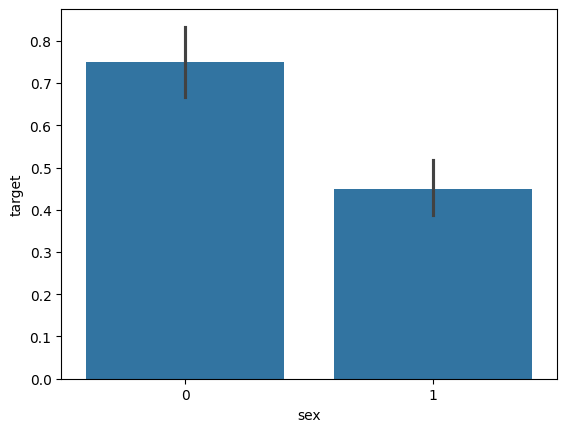

In [50]:
sns.barplot(x=df["sex"],y=y)

#females are more likely to have heart problems than males

In [60]:
#Train Test split
from sklearn.model_selection import train_test_split
predictors = df.drop("target",axis=1)
target = df["target"]

X_train,X_test,Y_train,Y_test = train_test_split(predictors,target,test_size=0.20,random_state=0)


#Logistic Regression


In [87]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

lr.fit(X_train,Y_train)

Y_pred_lr = lr.predict(X_test)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [88]:
score_lr = round(accuracy_score(Y_pred_lr,Y_test)*100,2)

print("The accuracy score achieved using Logistic Regression is: "+str(score_lr)+" %")

The accuracy score achieved using Logistic Regression is: 85.25 %


#Naive Bayes

In [70]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()

nb.fit(X_train,Y_train)

Y_pred_nb = nb.predict(X_test)

In [71]:
score_nb = round(accuracy_score(Y_pred_nb,Y_test)*100,2)

print("The accuracy score achieved using Naive Bayes is: "+str(score_nb)+" %")

The accuracy score achieved using Naive Bayes is: 85.25 %


#Decision Tree

In [72]:
from sklearn.tree import DecisionTreeClassifier

max_accuracy = 0

for x in range(200):
    dt = DecisionTreeClassifier(random_state=x)
    dt.fit(X_train,Y_train)
    Y_pred_dt = dt.predict(X_test)
    current_accuracy = round(accuracy_score(Y_pred_dt,Y_test)*100,2)
    if(current_accuracy>max_accuracy):
        max_accuracy = current_accuracy
        best_x = x

#print(max_accuracy)
#print(best_x)


dt = DecisionTreeClassifier(random_state=best_x)
dt.fit(X_train,Y_train)
Y_pred_dt = dt.predict(X_test)


In [73]:
score_dt = round(accuracy_score(Y_pred_dt,Y_test)*100,2)

print("The accuracy score achieved using Decision Tree is: "+str(score_dt)+" %")

The accuracy score achieved using Decision Tree is: 81.97 %


#Random Forest

In [75]:
from sklearn.ensemble import RandomForestClassifier
max_accuracy = 0
for x in range(2000):
    rf = RandomForestClassifier(random_state=x)
    rf.fit(X_train,Y_train)
    Y_pred_rf = rf.predict(X_test)
    current_accuracy = round(accuracy_score(Y_pred_rf,Y_test)*100,2)
    if(current_accuracy>max_accuracy):
        max_accuracy = current_accuracy
        best_x = x

#print(max_accuracy)
#print(best_x)

rf = RandomForestClassifier(random_state=best_x)
rf.fit(X_train,Y_train)
Y_pred_rf = rf.predict(X_test)


In [76]:
score_rf = round(accuracy_score(Y_pred_rf,Y_test)*100,2)

print("The accuracy score achieved using Decision Tree is: "+str(score_rf)+" %")

The accuracy score achieved using Decision Tree is: 90.16 %


#Output final score

In [77]:
scores = [score_lr,score_nb,score_dt,score_rf]
algorithms = ["Logistic Regression","Naive Bayes","Decision Tree","Random Forest"]

for i in range(len(algorithms)):
    print("The accuracy score achieved using "+algorithms[i]+" is: "+str(scores[i])+" %")

The accuracy score achieved using Logistic Regression is: 85.25 %
The accuracy score achieved using Naive Bayes is: 85.25 %
The accuracy score achieved using Decision Tree is: 81.97 %
The accuracy score achieved using Random Forest is: 90.16 %


<Axes: xlabel='Algorithms', ylabel='Accuracy score'>

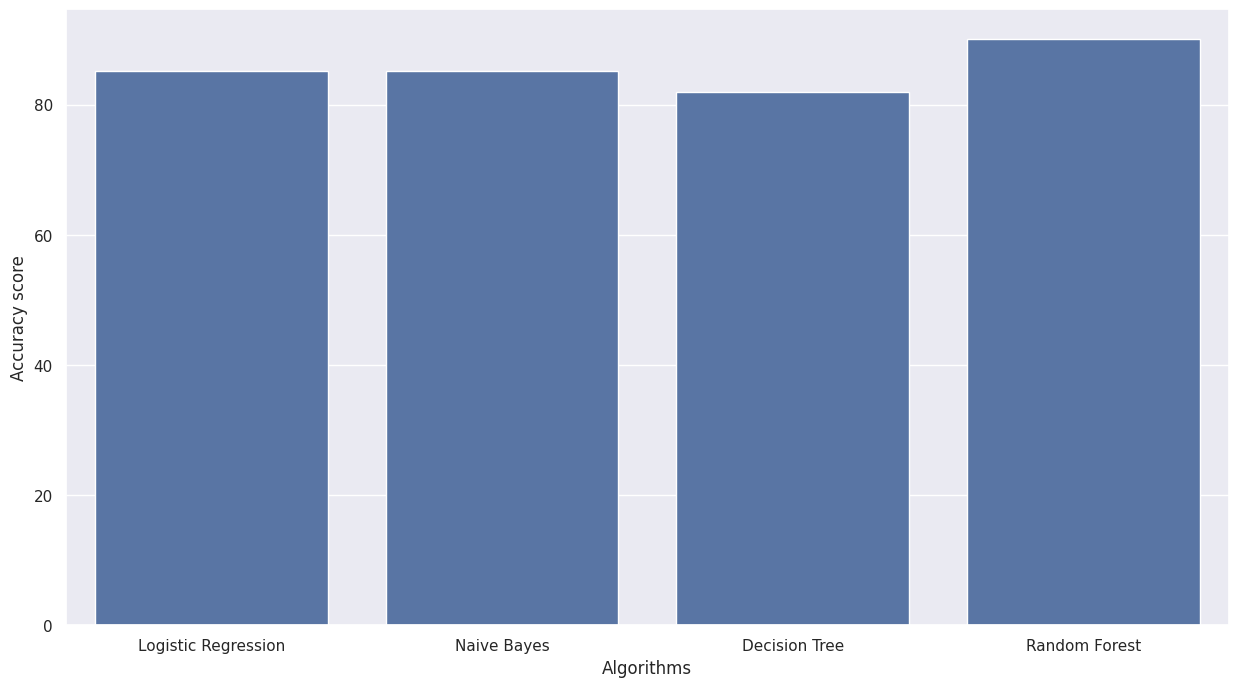

In [80]:
sns.set(rc={'figure.figsize':(15,8)})
plt.xlabel("Algorithms")
plt.ylabel("Accuracy score")

sns.barplot(x=algorithms,y=scores)

/tmp/ipython-input-221904377.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Algorithms', y='Accuracy', data=df_results, palette="muted")


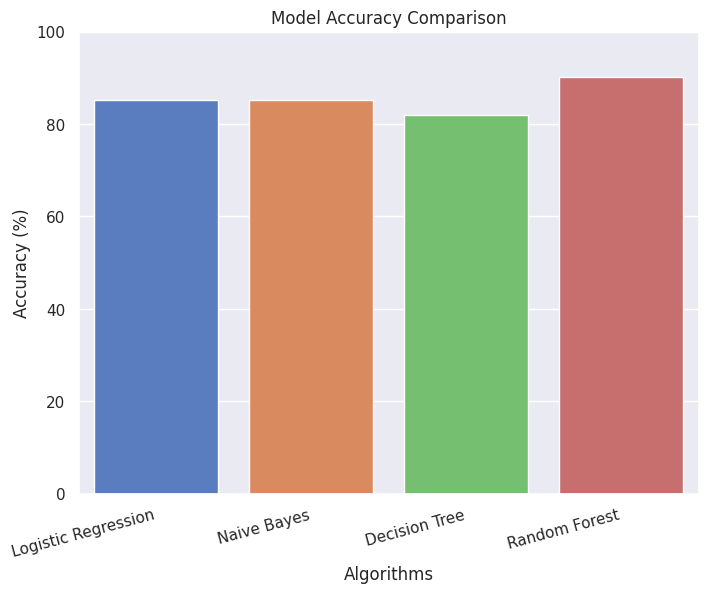

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Your existing scores and algorithms
scores = [score_lr, score_nb, score_dt, score_rf]
algorithms = ["Logistic Regression", "Naive Bayes", "Decision Tree", "Random Forest"]

# Convert to DataFrame
df_results = pd.DataFrame({
    'Algorithms': algorithms,
    'Accuracy': scores
})

# Plot
plt.figure(figsize=(8,6))
sns.barplot(x='Algorithms', y='Accuracy', data=df_results, palette="muted")

plt.xticks(rotation=15, ha='right')
plt.ylabel("Accuracy (%)")
plt.xlabel("Algorithms")
plt.title("Model Accuracy Comparison")
plt.ylim(0, 100)   # since your scores are in percentages
plt.show()
